In [35]:
### Import Statements
import sys, os, json, tqdm
sys.path.append('..')

In [36]:
### API Keys and Clients
from openai import OpenAI
from together import Together
from lib.utils.utils import load_api_keys
KEYS = load_api_keys()
client = OpenAI(api_key = KEYS["openai"])
client_together = Together(api_key=KEYS["togetherai"])

In [37]:
### Generate Dataset
from lib.data_generation.generate_dataset import generate_dataset
# NLP4LP
source_dataset_folder = '../data/nlp4lp'
target_dataset_folder = '../data/nlp4lp_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))
# NLOPT
source_dataset_folder = '../data/nl4opt'
target_dataset_folder = '../data/nl4opt_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))
# Complexor
source_dataset_folder = '../data/complexor'
target_dataset_folder = '../data/complexor_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))

In [38]:
### Dataset Statistics
import pandas as pd
from lib.utils.utils import check_file_existence

def dict_to_df(all_data):
    rows = []
    for dataset_name, dataset_data in all_data.items():
        for problem_idx_key, problem_idx_data in dataset_data.items():
            for key, data in problem_idx_data.items():
                row = {"Dataset Name": dataset_name, "Problem Index": problem_idx_key,'Field': key,'Data': data}
                rows.append(row)
            df = pd.DataFrame(rows)
    return df

dataset_folders = {"nlp4lp" : "../data/nlp4lp_task_disambiguation", "nl4opt": "../data/nl4opt_task_disambiguation", "complexor" : "../data/complexor_task_disambiguation"}
all_data = {}
for dataset_name, dataset_folder in dataset_folders.items():
    problems = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]
    source_problem_paths = {problem: dataset_folder + '/' + problem + '/' + 'input.json' for problem in problems}
    source_problem_paths = check_file_existence(source_problem_paths)[0]
    problems = list(source_problem_paths.keys())
    problems_dict = {}
    for problem in tqdm.tqdm(problems):
        problems_dict[problem] = {}
        with open(source_problem_paths[problem], "r") as f:
            state = json.load(f)
        problems_dict[problem]["vague_description_len"] = len(state["vague_description"].split())
        problems_dict[problem]["detailed_description_len"] = len(state["detailed_description"].split())
        problems_dict[problem]["num_constraints"] = len(state["target_constraints"])
    all_data[dataset_name] = problems_dict
all_data = dict_to_df(all_data)
df = all_data.pivot_table(index=['Dataset Name', 'Problem Index'],columns='Field',values='Data').reset_index() # pivot table
df.columns.name = None

100%|██████████| 20/20 [00:00<00:00, 7892.19it/s]


In [39]:
dataset_mean_table = df.groupby('Dataset Name')[["num_constraints", "detailed_description_len", "vague_description_len"]].mean().reset_index().round(2)
dataset_std_table = df.groupby('Dataset Name')[["num_constraints", "detailed_description_len", "vague_description_len"]].std().reset_index().round(2)
# dataset_mean_table, dataset_std_table
pd.concat({"mean": dataset_mean_table, "std": dataset_std_table})

Dataset Name  num_constraints  detailed_description_len  \
mean 0    complexor             3.80                    103.00   
     1       nl4opt             5.69                    100.37   
     2       nlp4lp             3.79                     67.21   
std  0    complexor             1.44                     26.15   
     1       nl4opt             2.01                     18.14   
     2       nlp4lp             2.10                     29.81   

        vague_description_len  
mean 0                  16.95  
     1                  20.36  
     2                  17.35  
std  0                   4.97  
     1                   5.58  
     2                   4.90

In [40]:
# indexes based on question length
bounds = {'short':(0, 50), # 19 questions
          'medium' : (50,75), # 19 questions
          'long':(75, 150), #24 questions
        }
subset_quesiton_length_f = lambda lower_bound, upper_bound: df[(df['detailed_description_len'] >= lower_bound) & (df['detailed_description_len'] < upper_bound) & (df['Dataset Name'] == 'nlp4lp')]
subset_quesiton_length = {bound: subset_quesiton_length_f(lower_bound=bounds[bound][0], upper_bound=bounds[bound][1])["Problem Index"].values for bound in bounds}

# indexes based on length ratio
bounds = {'1_05':(0.5, 1), # 19 questions
          '05_03' : (0.3,0.5), # 19 questions
          '03_02':(0.2, 0.3), #24 questions
          '02_00':(0, 0.2), #24 questions
        }
df["vague_detailed_ratio"] = df["vague_description_len"] / df["detailed_description_len"]
subset_length_ratio_f = lambda lower_bound, upper_bound: df[(df['vague_detailed_ratio'] >= lower_bound) & (df['vague_detailed_ratio'] < upper_bound) & (df['Dataset Name'] == 'nlp4lp')]
subset_length_ratio = {bound: subset_length_ratio_f(lower_bound=bounds[bound][0], upper_bound=bounds[bound][1])["Problem Index"].values for bound in bounds}

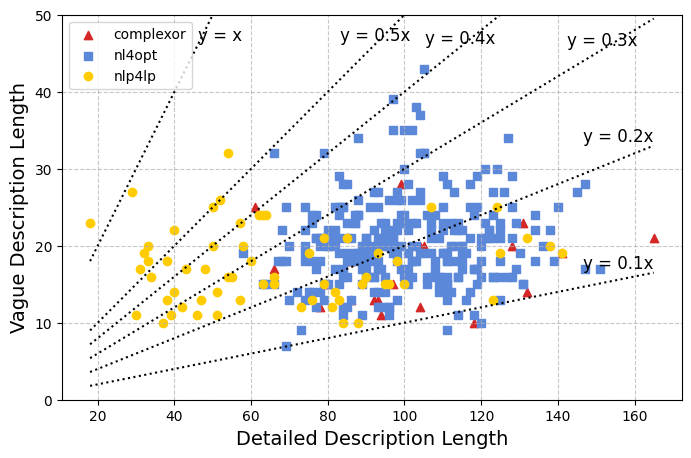

In [41]:
import matplotlib.pyplot as plt

# markers and colors
markers = {'nlp4lp': 'o', 'nl4opt': 's', 'complexor': '^'}
colors = {'nlp4lp': '#ffcc00', 'nl4opt': '#5c88da', 'complexor': '#d62728'}
# colors = {'nlp4lp': '#1f77b4', 'nl4opt': '#2ca02c', 'complexor': '#d62728'}  # Blue, Green, Red
plt.figure(figsize=(8, 5))
import pandas as pd
import numpy as np
# data for each dataset
for dataset_name in df['Dataset Name'].unique():
    subset = df[df['Dataset Name'] == dataset_name]
    plt.scatter(
        subset['detailed_description_len'],
        subset['vague_description_len'],
        marker=markers[dataset_name],
        color=colors[dataset_name],
        label=dataset_name
    )
# add lines
x = np.linspace(min(df['detailed_description_len']), max(df['detailed_description_len']), 100)
plt.plot(x, x, linestyle='dotted', color='black')  # Line x = y
plt.text(x[-81], x[-81], 'y = x', fontsize=12, ha='left', va='bottom', color='black')
plt.plot(x, 0.5*x, linestyle='dotted', color='black')  # Line x = 0.5y
plt.text(x[-50], 0.5*x[-50], 'y = 0.5x', fontsize=12, ha='center', va='bottom', color='black')
plt.plot(x, 0.4*x, linestyle='dotted', color='black')  # Line x = 0.4y
plt.text(x[-35], 0.4*x[-35], 'y = 0.4x', fontsize=12, ha='center', va='bottom', color='black')
plt.plot(x, 0.3*x, linestyle='dotted', color='black')  # Line x = 0.3y
plt.text(x[-10], 0.3*x[-10], 'y = 0.3x', fontsize=12, ha='center', va='bottom', color='black')
plt.plot(x, 0.2*x, linestyle='dotted', color='black')  # Line x = 0.2y
plt.text(x[-1], 0.2*x[-1], 'y = 0.2x', fontsize=12, ha='right', va='bottom', color='black')
plt.plot(x, 0.1*x, linestyle='dotted', color='black')  # Line x = 0.1y
plt.text(x[-1], 0.1*x[-1], 'y = 0.1x', fontsize=12, ha='right', va='bottom', color='black')
plt.xlabel('Detailed Description Length', fontsize=14)
plt.ylabel('Vague Description Length', fontsize=14)
plt.ylim(0, 50)
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()